## Mathematical Framework

### 1. Price Process and Returns

Let $ P_t $ denote the Oslo OBX index level at time $ t $.
The (simple) daily return is computed as

$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$

Similarly, the market return used in CAPM is

$
R_t^{m} = \frac{P_t^{m} - P_{t-1}^{m}}{P_{t-1}^{m}}
$

where $ P_t^{m} $ is the OBX price.

---

### 2. Risk-Free Rate

Let $ y_t $ denote the annualized Norwegian 10-year government bond yield (in percent).
It is converted to a daily risk-free rate as

$
R_t^{f} = \frac{y_t}{100 \cdot 252}
$

---

### 3. Moving Averages

For a window length $ n \in \{50, 100, 200\} $, the simple moving average (SMA) is defined as

$
\text{SMA}_{t}^{(n)} = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}
$

---

### 4. Trading Signal (Golden Cross / Death Cross)

The trading signal is based on the relative position of the short-term and long-term moving averages.

$
S_t =
\begin{cases}
1, & \text{if } \text{SMA}_{t}^{(50)} > \text{SMA}_{t}^{(200)} \\
0, & \text{otherwise}
\end{cases}
$

To avoid look-ahead bias, the position is lagged by one period:

$
\pi_t = S_{t-1}
$

where $ \pi_t \in \{0,1\} $ denotes the portfolio exposure.

---

### 5. Strategy Returns

The strategy return at time $ t $ is

$
R_t^{\text{strat}} = \pi_t \cdot R_t^{m}
$

---

### 6. Cumulative Returns

Cumulative returns for the strategy and the market are computed multiplicatively:

$
\text{CR}_T^{\text{strat}} = \prod_{t=1}^{T} (1 + R_t^{\text{strat}}) - 1
$

$
\text{CR}_T^{m} = \prod_{t=1}^{T} (1 + R_t^{m}) - 1
$

---

### 7. Excess Returns

Excess returns over the risk-free rate are defined as

$
\tilde{R}_t^{\text{strat}} = R_t^{\text{strat}} - R_t^{f}
$

$
\tilde{R}_t^{m} = R_t^{m} - R_t^{f}
$

---

### 8. CAPM Regression Model

The Capital Asset Pricing Model (CAPM) is estimated via ordinary least squares (OLS):

$
\tilde{R}_t^{\text{strat}} = \alpha + \beta \tilde{R}_t^{m} + \varepsilon_t
$

where:
- $ \alpha $ measures abnormal performance (strategy alpha),
- $ \beta $ measures market exposure,
- $ \varepsilon_t $ is an error term with $ \mathbb{E}[\varepsilon_t] = 0 $.

---

### 9. Estimation and Inference

The OLS estimator is

$
\hat{\theta} = (X^\top X)^{-1} X^\top y
$

with
$
X = \begin{pmatrix}
1 & \tilde{R}_1^{m} \\
\vdots & \vdots \\
1 & \tilde{R}_T^{m}
\end{pmatrix},
\quad
y = \begin{pmatrix}
\tilde{R}_1^{\text{strat}} \\
\vdots \\
\tilde{R}_T^{\text{strat}}
\end{pmatrix}
$

Statistical significance of $ \alpha $ is assessed using a $ t $-test:

$
t_\alpha = \frac{\hat{\alpha}}{\text{SE}(\hat{\alpha})}
$

The associated $ p $-value tests the null hypothesis

$
H_0 : \alpha = 0
$

---

### 10. Interpretation

- A statistically significant $ \alpha > 0 $ indicates risk-adjusted outperformance.
- $ \beta \approx 1 $ implies market-like exposure.
- $ \beta < 1 $ indicates defensive behavior due to time spent out of the market.


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Load data ---
obx = pd.read_csv("Oslo OBX Historical Data.csv")
rf = pd.read_csv("Norway 10-Year Bond Yield Historical Data.csv")

# --- Preprocess ---
for df in [obx, rf]:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

obx = obx.sort_values("Date")
rf = rf.sort_values("Date")

# --- Merge on dates ---
data = pd.merge(obx[["Date", "Price"]], rf[["Date", "Price"]],
                on="Date", how="inner", suffixes=("_obx", "_rf"))

# --- Returns ---
data["ret_mkt"] = data["Price_obx"].pct_change()
data["rf"] = data["Price_rf"] / 100 / 252   # annual yield → daily rate

# --- Moving averages ---
for w in [50, 100, 200]:
    data[f"ma{w}"] = data["Price_obx"].rolling(w).mean()

# --- Trading strategy (Golden/Death Cross: 50 vs 200) ---
data["signal"] = 0
data.loc[data["ma50"] > data["ma200"], "signal"] = 1
data["position"] = data["signal"].shift(1)

data["strategy_ret"] = data["position"] * data["ret_mkt"]

# --- Store trades ---
data["trade"] = data["position"].diff()
trades = data.loc[data["trade"] != 0, ["Date", "Price_obx", "trade"]]

# --- CAPM regression ---
capm = data.dropna(subset=["strategy_ret", "ret_mkt", "rf"])
capm["excess_strat"] = capm["strategy_ret"] - capm["rf"]
capm["excess_mkt"] = capm["ret_mkt"] - capm["rf"]

X = sm.add_constant(capm["excess_mkt"])
y = capm["excess_strat"]

model = sm.OLS(y, X).fit()

# --- Results ---
# print("Alpha:", model.params["const"])
# print("Alpha p-value:", model.pvalues["const"])
# print("Beta:", model.params["excess_mkt"])
# print("Total return:", (1 + data["strategy_ret"]).prod() - 1)
# print("Number of trades:", trades.shape[0])
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           excess_strat   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     3374.
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:08:34   Log-Likelihood:                 16540.
No. Observations:                4796   AIC:                        -3.308e+04
Df Residuals:                    4794   BIC:                        -3.306e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.167e-06      0.000     -0.037      0.9

C:\Users\naths\AppData\Local\Temp\ipykernel_38104\925816216.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capm["excess_strat"] = capm["strategy_ret"] - capm["rf"]
C:\Users\naths\AppData\Local\Temp\ipykernel_38104\925816216.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capm["excess_mkt"] = capm["ret_mkt"] - capm["rf"]


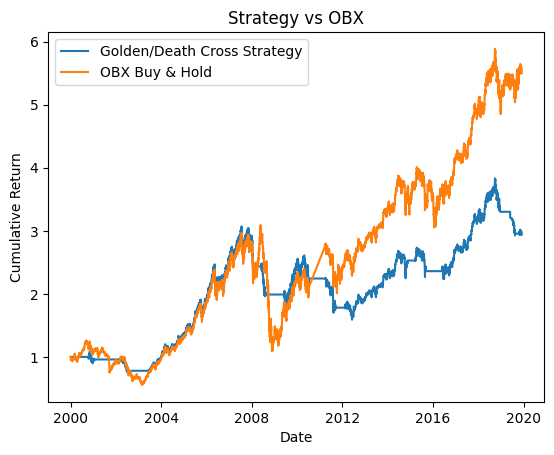

In [6]:
import matplotlib.pyplot as plt

# --- Cumulative returns ---
data["cum_strategy"] = (1 + data["strategy_ret"].fillna(0)).cumprod()
data["cum_market"] = (1 + data["ret_mkt"].fillna(0)).cumprod()

# --- Plot ---
plt.figure()
plt.plot(data["Date"], data["cum_strategy"], label="Golden/Death Cross Strategy")
plt.plot(data["Date"], data["cum_market"], label="OBX Buy & Hold")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Strategy vs OBX")
plt.show()


## Conclusion

It doesn't work fellas

## Now with transaction costs

C:\Users\naths\AppData\Local\Temp\ipykernel_38104\3422814426.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capm["excess_strat"] = capm["strategy_ret"] - capm["rf"]
C:\Users\naths\AppData\Local\Temp\ipykernel_38104\3422814426.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capm["excess_mkt"] = capm["ret_mkt"] - capm["rf"]


                            OLS Regression Results                            
Dep. Variable:           excess_strat   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     3374.
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:18:55   Log-Likelihood:                 16539.
No. Observations:                4796   AIC:                        -3.307e+04
Df Residuals:                    4794   BIC:                        -3.306e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.148e-06      0.000     -0.055      0.9

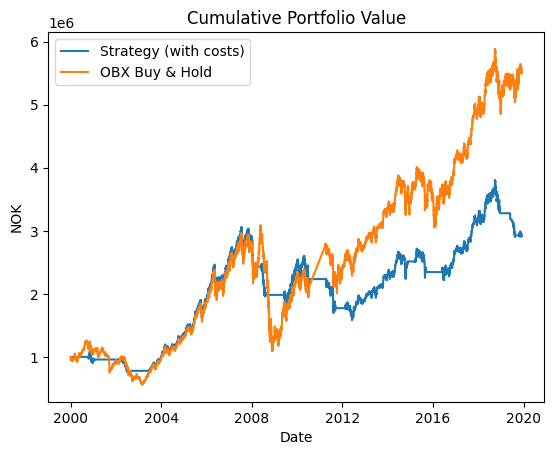

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Parameters ---
tc = 0.00035
initial_capital = 1_000_000

# --- Load data ---
obx = pd.read_csv("Oslo OBX Historical Data.csv")
rf = pd.read_csv("Norway 10-Year Bond Yield Historical Data.csv")

for df in [obx, rf]:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

obx = obx.sort_values("Date")
rf = rf.sort_values("Date")

# --- Merge ---
data = pd.merge(
    obx[["Date", "Price"]],
    rf[["Date", "Price"]],
    on="Date",
    how="inner",
    suffixes=("_obx", "_rf")
)

# --- Returns ---
data["ret_mkt"] = data["Price_obx"].pct_change()
data["rf"] = data["Price_rf"] / 100 / 252

# --- Moving averages ---
for w in [50, 100, 200]:
    data[f"ma{w}"] = data["Price_obx"].rolling(w).mean()

# --- Strategy ---
data["signal"] = (data["ma50"] > data["ma200"]).astype(int)
data["position"] = data["signal"].shift(1).fillna(0)

# --- Trades & transaction costs ---
data["trade"] = data["position"].diff().abs().fillna(0)
data["tc"] = data["trade"] * tc

# --- Strategy returns with costs ---
data["strategy_ret"] = data["position"] * data["ret_mkt"] - data["tc"]

# --- Portfolio value ---
data["portfolio"] = initial_capital * (1 + data["strategy_ret"].fillna(0)).cumprod()
data["market"] = initial_capital * (1 + data["ret_mkt"].fillna(0)).cumprod()

# --- CAPM ---
capm = data.dropna(subset=["strategy_ret", "ret_mkt", "rf"])
capm["excess_strat"] = capm["strategy_ret"] - capm["rf"]
capm["excess_mkt"] = capm["ret_mkt"] - capm["rf"]

X = sm.add_constant(capm["excess_mkt"])
y = capm["excess_strat"]
model = sm.OLS(y, X).fit()

print(model.summary())

# --- Plot ---
plt.figure()
plt.plot(data["Date"], data["portfolio"], label="Strategy (with costs)")
plt.plot(data["Date"], data["market"], label="OBX Buy & Hold")
plt.legend()
plt.xlabel("Date")
plt.ylabel("NOK")
plt.title("Cumulative Portfolio Value")
plt.show()


Not much change